In [8]:
import sys
sys.path.append('../../Models')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import seaborn as sns

from pylab import rcParams
from scipy.interpolate import interp1d
rcParams['figure.figsize'] = 10, 10

from RealNVP import *
from sklearn import datasets

In [9]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [10]:
device = "cpu"

In [11]:
# Only run once, then load saved model
# flow = train(datasets, max_epochs=10000)

In [21]:
# Load flow
# path_model = "TrainedModels/flow.pth"
# flow = RealNVP(tfm_layers=6, latent_dim=2, device=device).to(device)
path_model = "TrainedModels/flow_mix.pth"
flow = RealNVP(tfm_layers=6, latent_dim=2, device=device, distribution="mixture", num_modes=2).to(device)
flow.load_state_dict(torch.load(path_model))
flow.eval()

RealNVP(
  (block_scale): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Tanh()
  )
  (block_trans): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (net_trans): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_f

Text(0.5, 1.0, '$X = g(z)$')

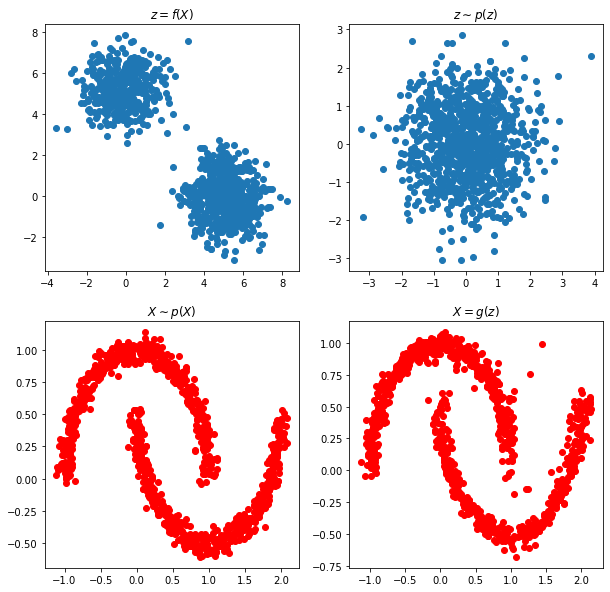

In [22]:
fig = plt.figure()
fig.patch.set_facecolor('w')

noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.to_latent(torch.from_numpy(noisy_moons).to(device))[0].cpu().detach().numpy()

plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000, False).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## Heatmap of condition number

tensor([[[0.0569, 0.2006]],

        [[0.0570, 0.1991]],

        [[0.0571, 0.1977]],

        ...,

        [[0.1088, 0.3932]],

        [[0.1088, 0.3898]],

        [[0.1088, 0.3865]]], grad_fn=<MulBackward0>)


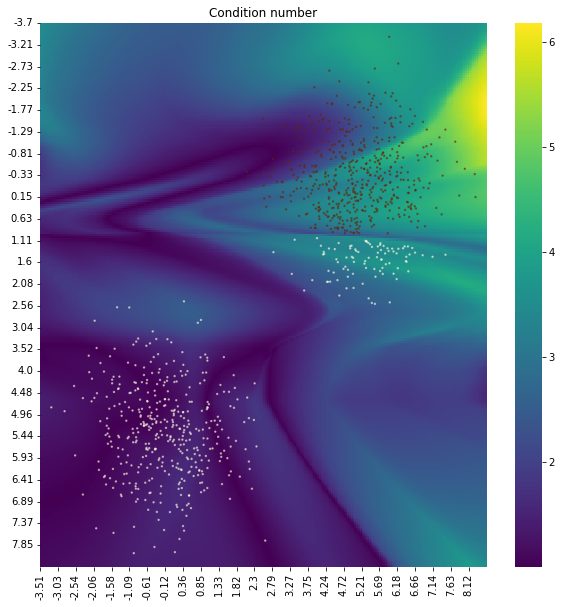

In [35]:
plt.close(fig)

fig = plt.figure()
fig.patch.set_facecolor('w')

# First sample the dataset and outputs
x, y = datasets.make_moons(n_samples=1000, noise=.05)
x = x.astype(np.float32)
z = flow.to_latent(torch.from_numpy(x).to(device))[0].cpu().detach().numpy()

# Bounding box
x_x_min = x[:, 0].min() - 0.2
x_x_max = x[:, 0].max() + 0.2
x_y_min = x[:, 1].min() - 0.2
x_y_max = x[:, 1].max() + 0.2

z_x_min = z[:, 0].min() - 0.3
z_x_max = z[:, 0].max() + 0.3
z_y_min = z[:, 1].min() - 0.3
z_y_max = z[:, 1].max() + 0.3

steps = 250
z_xs = torch.linspace(z_x_min, z_x_max, steps=steps)
z_ys = torch.linspace(z_y_min, z_y_max, steps=steps)

z_xgrid, z_ygrid = torch.meshgrid(z_xs, z_ys, indexing='xy')
pts_grid = torch.hstack((z_xgrid.reshape(-1,1), z_ygrid.reshape(-1,1)))[:, None, :]

x_recon, cond_nums = flow.to_image(pts_grid.to(device), flag_condition=True)

cond_nums = cond_nums.detach().reshape(steps, steps)
g = sns.heatmap(cond_nums, cmap="viridis")

# Interpolate
interp_x = interp1d([z_x_min, z_x_max], [0, steps])
interp_y = interp1d([z_y_min, z_y_max], [0, steps])
interp_z_x = interp_x(z[:, 0])
interp_z_y = interp_y(z[:, 1])
plt.scatter(interp_z_x, interp_z_y, c=y, s=2, alpha=0.5, cmap="YlOrBr")
g.set_xticks(list(range(len(z_xs)))[::10])
g.set_xticklabels([str(round(float(label), 2)) for label in z_xs[::10].to(torch.float16).tolist()])
g.set_yticks(list(range(len(z_ys)))[::10])
g.set_yticklabels([str(round(float(label), 2)) for label in z_ys[::10].to(torch.float16).tolist()])

plt.title("Condition number")

plt.savefig("Outputs/condition_number_wrong", transparent=False)

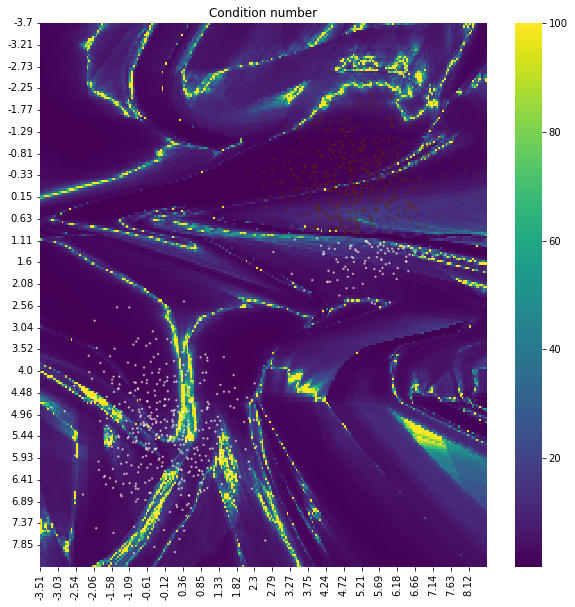

In [36]:
plt.close(fig)

fig = plt.figure()
fig.patch.set_facecolor('w')

z_xgrid, z_ygrid = torch.meshgrid(z_xs, z_ys, indexing='xy')
pts_grid = torch.hstack((z_xgrid.reshape(-1,1), z_ygrid.reshape(-1,1)))

jacob = flow.get_condition_number_to_image(pts_grid)
eig_vals, eig_vecs = np.linalg.eigh(jacob)
cond_nums = np.abs(eig_vals.max(axis=1) / eig_vals.min(axis=1))

cond_nums = cond_nums.reshape(steps, steps)
cond_nums = np.clip(cond_nums, -100, 100)
g = sns.heatmap(cond_nums, cmap="viridis")

# Interpolate
interp_x = interp1d([z_x_min, z_x_max], [0, steps])
interp_y = interp1d([z_y_min, z_y_max], [0, steps])
interp_z_x = interp_x(z[:, 0])
interp_z_y = interp_y(z[:, 1])
plt.scatter(interp_z_x, interp_z_y, c=y, s=2, alpha=0.5, cmap="YlOrBr")
g.set_xticks(list(range(len(z_xs)))[::10])
g.set_xticklabels([str(round(float(label), 2)) for label in z_xs[::10].to(torch.float16).tolist()])
g.set_yticks(list(range(len(z_ys)))[::10])
g.set_yticklabels([str(round(float(label), 2)) for label in z_ys[::10].to(torch.float16).tolist()])

plt.title("Condition number")

plt.savefig("Outputs/condition_number", transparent=False)

## Scratch